# ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [33]:
from statsmodels.tsa.stattools import adfuller

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
data = pd.read_csv('data/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [4]:
# Find the number of ETFs
print(data['Ticker'].nunique())

# Display unique tickers
ticker_name = data['Ticker'].unique().tolist()
ticker_name

15


['VNQ',
 'IYR',
 'SCHH',
 'ICF',
 'USRT',
 'RWR',
 'REM',
 'REZ',
 'KBWY',
 'MORT',
 'PSR',
 'FRI',
 'ROOF',
 'RDOG',
 'REK']

## VNQ

In [5]:
vnq = data.loc[data['Ticker'] == "VNQ"]
display(vnq)
display(vnq.shape)
display(vnq.info())

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
4208,2021-06-17,103.410004,103.699997,102.860001,103.550003,5055100,0.0,0.0,VNQ
4209,2021-06-18,103.019997,103.470001,101.790001,101.790001,5358000,0.0,0.0,VNQ
4210,2021-06-21,102.309998,104.209999,101.800003,103.889999,3672900,0.0,0.0,VNQ
4211,2021-06-22,103.889999,104.010002,103.279999,103.349998,3088200,0.0,0.0,VNQ


(4213, 9)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4213 entries, 0 to 4212
Data columns (total 9 columns):
Date            4213 non-null object
Open            4213 non-null float64
High            4213 non-null float64
Low             4213 non-null float64
Close           4213 non-null float64
Volume          4213 non-null int64
Dividends       4213 non-null float64
Stock Splits    4213 non-null float64
Ticker          4213 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 329.1+ KB


None

## Preprocessing

In [6]:
# Convert Date column to datetime64 type
vnq['Date'] = pd.to_datetime(vnq['Date'])

# Set index to a datetime index
vnq.set_index('Date', inplace=True)

# Check
display(vnq.head())

print(vnq.index.inferred_type == "datetime64")

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ


True


In [7]:
def visualize_time_series(TS):
    TS.plot(figsize=(15,9))
    plt.title("Close")
    plt.ylabel("Price")
    plt.show()

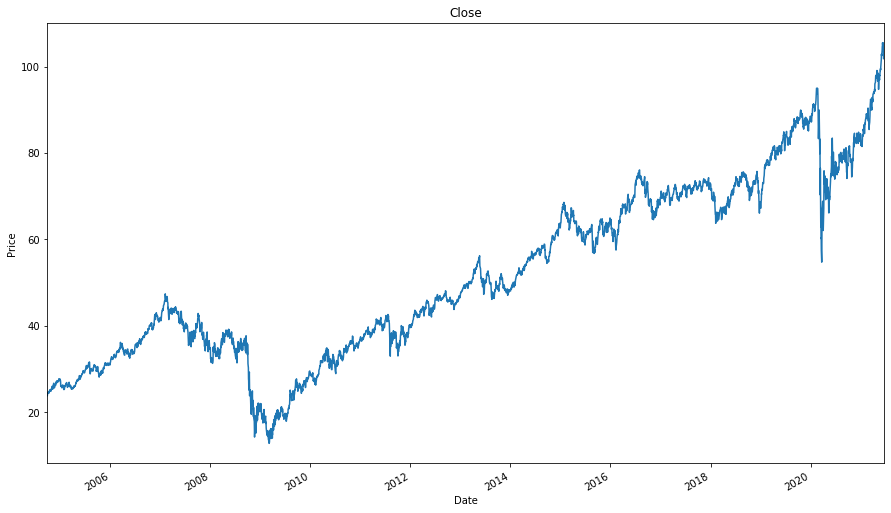

In [8]:
visualize_time_series(vnq['Close'])

In [12]:
# Check for null value
vnq.isna().any().any()

# vnq.loc[vnq['Close'].isna() == True]

False

## Stationary Check + Decomposition Plot

In [18]:
# Put those library in py.file!!!

# import numpy as np
# from statsmodels.tsa.stattools import adfuller

# from pmdarima.arima import decompose
# from pmdarima.utils import decomposed_plot


def stationary_check(TS, window_size):
    '''
    TS: Time Series
    
    window_size
    
    '''
    
    # Rolling Statistics
    roll_mean = TS.rolling(window=window_size, center=False).mean()
    roll_std = TS.rolling(window=window_size, center=False).std()
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(TS, color='blue', label='Original')
    plt.plot(roll_mean, color = 'red', label='Rolling Mean')
    plt.plot(roll_std, color = 'black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block=False)
    
    
    # Dickey-Fuller Test
    dftest = adfuller(TS)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 
                                             'p-value', 
                                             '#Lags Used', 
                                             'Number of Observations Used'])
    
    # Determine stationarity based on p value
    if dfoutput[1] < 0.05:
        print("Stationary, because p < 0.05 \n")
    else:
        print("Non-stationary, because p ≥ 0.05 \n")
    
    # Print Dickey-Fuller Test Result
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print('Results of Dickey-Fuller test: \n')
    print(dfoutput)
    
    


def decomposition_plot(TS, frequency):
    '''
    TS: Time Series
    '''
    # Use decompose function from pmdarima
    decomposed = decompose(TS.values, 'multiplicative', m=frequency) # use "multiplicative" when see an increasing trend
    
    # Plot the decomposition plot
    decomposed_plot(decomposed, figure_kwargs={'figsize': (12,10)})
    

    
def decomposition_plot_2(TS, frequency):
    decomposition = seasonal_decompose(TS, freq=frequency)


    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(TS, label='Original', color='blue')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')

    plt.tight_layout()

[additive or multiplicative?](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.decompose.html)

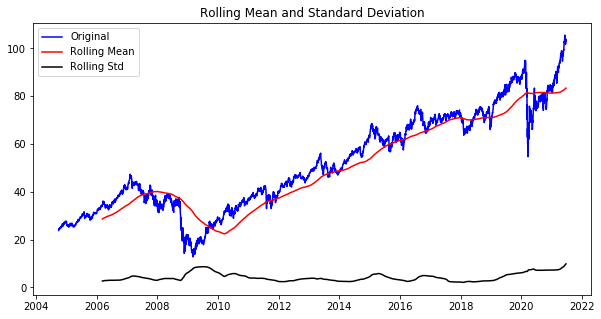

Non-stationary, because p ≥ 0.05 

Results of Dickey-Fuller test: 

Test Statistic                    0.206874
p-value                           0.972645
#Lags Used                       29.000000
Number of Observations Used    4183.000000
Critical Value (1%)              -3.431914
Critical Value (5%)              -2.862231
Critical Value (10%)             -2.567138
dtype: float64


In [15]:
stationary_check(vnq['Close'], 365)

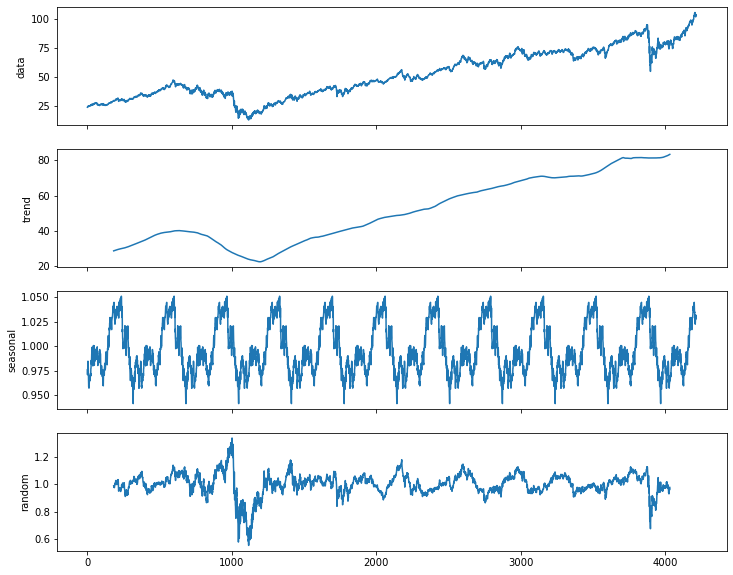

In [16]:
decomposition_plot(vnq['Close'], 365)

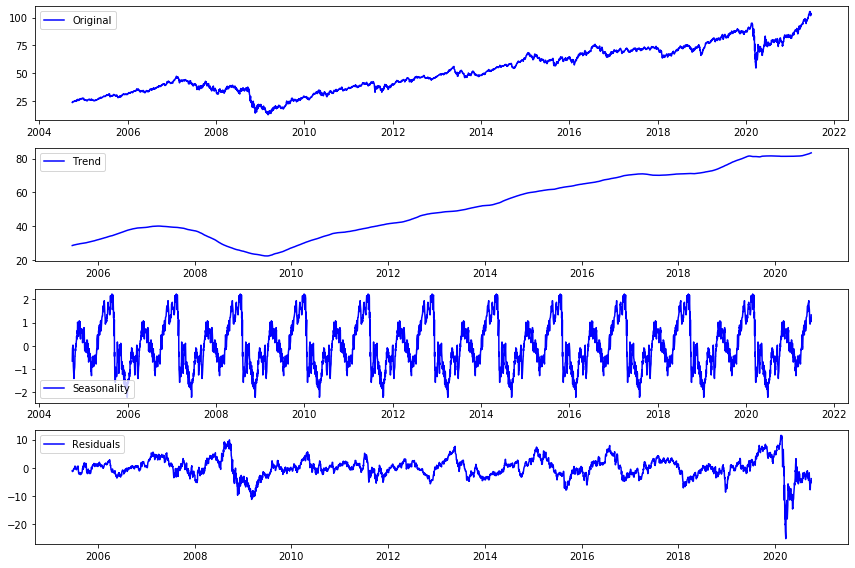

In [19]:
decomposition_plot_2(vnq['Close'], 365)

## Resample
- [frequency](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

In [29]:
vnq_M = vnq.resample('MS').mean()
vnq_M

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-09-01,23.830344,23.942516,23.825571,23.890009,1.168500e+05,0.000000,0.0
2004-10-01,24.807606,24.909662,24.707368,24.822381,1.957619e+04,0.000000,0.0
2004-11-01,25.939772,26.060921,25.736569,25.897495,3.158095e+04,0.000000,0.0
2004-12-01,27.197967,27.315034,27.046976,27.214131,2.781364e+04,0.057727,0.0
2005-01-01,26.124964,26.235272,25.808930,25.945349,4.756000e+04,0.000000,0.0
...,...,...,...,...,...,...,...
2021-02-01,88.229403,88.752659,87.543414,88.237252,3.981411e+06,0.000000,0.0
2021-03-01,89.774238,90.487633,88.995329,89.825299,4.478878e+06,0.022870,0.0
2021-04-01,95.868095,96.353810,95.390000,96.027142,4.298429e+06,0.000000,0.0


## Slicing

In [22]:
vnq_2011 = vnq.loc['2011-01-01':]
vnq_2011

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2011-01-03,36.998427,37.449627,36.978522,37.423088,1957400,0.0,0.0,VNQ
2011-01-04,37.476165,37.575695,36.494141,36.706470,2315700,0.0,0.0,VNQ
2011-01-05,36.593686,36.912180,36.587049,36.839191,1512700,0.0,0.0,VNQ
2011-01-06,36.938704,36.945341,36.474236,36.494141,1819300,0.0,0.0,VNQ
2011-01-07,36.686573,36.792738,36.162384,36.507420,2001200,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...
2021-06-17,103.410004,103.699997,102.860001,103.550003,5055100,0.0,0.0,VNQ
2021-06-18,103.019997,103.470001,101.790001,101.790001,5358000,0.0,0.0,VNQ
2021-06-21,102.309998,104.209999,101.800003,103.889999,3672900,0.0,0.0,VNQ


In [23]:
vnq_2020 = vnq.loc['2020-01-01':]
vnq_2020

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2020-01-02,88.898958,88.946652,86.905191,87.477562,5106600,0.0,0.0,VNQ
2020-01-03,87.038745,88.202570,86.838416,88.021317,5015500,0.0,0.0,VNQ
2020-01-06,87.925914,88.441050,87.639732,88.126244,4889000,0.0,0.0,VNQ
2020-01-07,87.935476,87.935476,86.666715,87.143692,6529100,0.0,0.0,VNQ
2020-01-08,87.181843,87.582501,86.867036,87.410789,6766100,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...
2021-06-17,103.410004,103.699997,102.860001,103.550003,5055100,0.0,0.0,VNQ
2021-06-18,103.019997,103.470001,101.790001,101.790001,5358000,0.0,0.0,VNQ
2021-06-21,102.309998,104.209999,101.800003,103.889999,3672900,0.0,0.0,VNQ


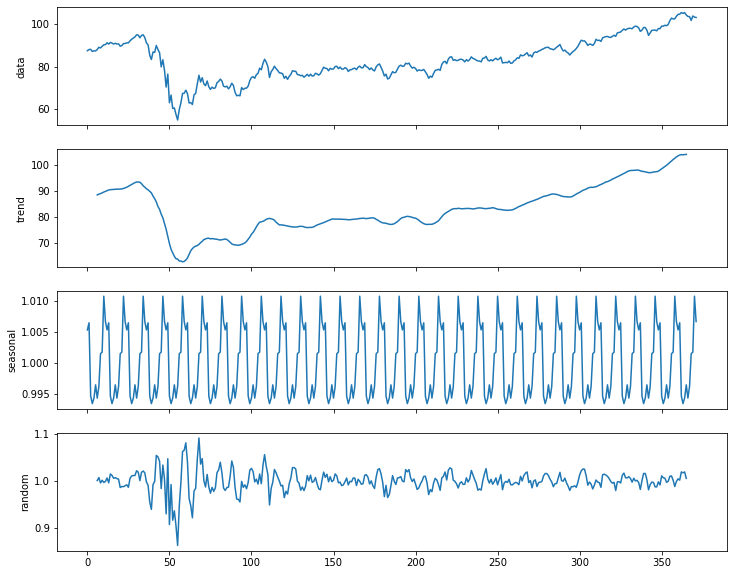

In [24]:
decomposition_plot(vnq_2020['Close'], 12)

## Detrend

In [20]:
def detrend_transformation(TS, log=True, sqrt=True):
    if log == True:
        TS_log = np.log(TS)
        return TS_log

    elif sqrt == True:
        TS_sqrt = np.sqrt(TS)
        return TS_sqrt
    
    else:
        print("Error")
        return None
        

def detrend_rolling_mean(TS, regular=True, window_size=None, half_life=None):
    if regular == True:
        rolling_mean = TS.rolling(window=window_size).mean()
            
        TS_minus_rolling_mean = TS - rolling_mean
        TS_minus_rolling_mean.dropna(inplace=True)
        return TS_minus_rolling_mean
    
    else:
        exp_rolling_mean = TS.ewm(halflife=half_life).mean()
        
        TS_minus_exp_rolling_mean = TS- exp_rolling_mean
        TS_minus_exp_rolling_mean.dropna(inplace=True)
        return TS_minus_exp_rolling_mean
    

def detrend_differencing(TS, periods):
    
    TS_diff = TS.diff(periods=periods)
    TS_diff.dropna(inplace=True)
    return TS_diff

### Test detrend function

In [25]:
ts = detrend_rolling_mean(vnq_2020['Close'], regular=False, half_life=4)

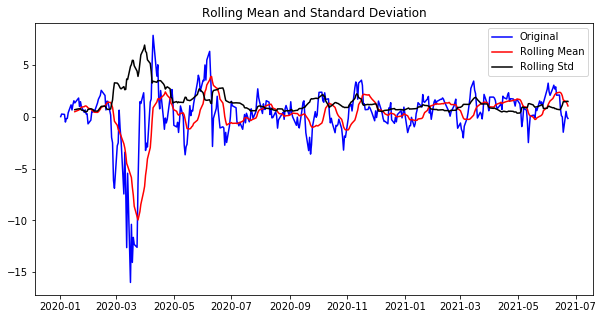

Stationary, because p < 0.05 

Results of Dickey-Fuller test: 

Test Statistic                  -4.691257
p-value                          0.000087
#Lags Used                       9.000000
Number of Observations Used    362.000000
Critical Value (1%)             -3.448544
Critical Value (5%)             -2.869557
Critical Value (10%)            -2.571041
dtype: float64


In [26]:
stationary_check(ts, 12)

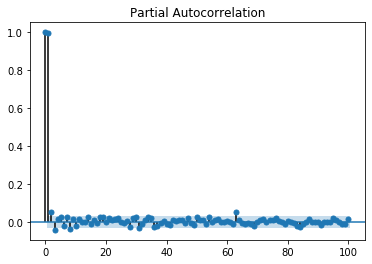

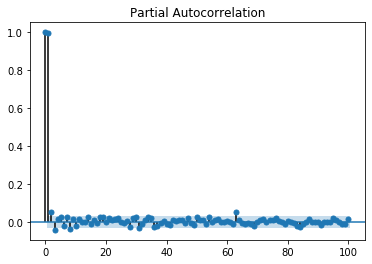

In [40]:
# fig,ax = plt.subplots(figsize=(10,4))
plot_pacf(vnq['Close'], lags=100)

In [41]:
import statsmodels.graphics.tsaplots as tsa